In [1]:
import numpy as np
from BCBio import GFF
import matplotlib.pyplot as plt

%matplotlib inline

#### Подготовка данных

In [2]:
def wig_parser(file, gsize):
    counts = np.zeros(gsize)
    with open(file, 'r') as file:
        file.readline()
        for line in file:
            data = line.split()
            position, count = int(data[0]), int(data[1])
            position = position - 2
            counts[position] = count
        return counts
    
forward = wig_parser('02. RiboSeq_EColi_track_f.wig', 4641668)
backward = wig_parser('02. RiboSeq_EColi_track_r.wig', 4641668)

In [3]:
genbank_filename = "sequence.gff3"
with open(genbank_filename) as f:
    records = list(GFF.parse(f, limit_info={'gff_type': ['CDS']}))
record = records[0]

1. Присутствует ли в покрытии генома неравномерность? Рассмотрите неравномерность покрытия на примере любого выбранного вами гена. Что вы можете сказать про эту неравномерность? Присутствует ли там периодичность в три нуклеотида? А если взять среднее по большому количеству генов (взяв за точку отсчёта старт-кодон)? Выводы проиллюстрируйте графиками.

In [4]:
features = []
for feature in record.features:
    if feature.type == 'CDS':
        features.append(feature)
print(len(features))

4270


#### Для одного гена

In [5]:
feature = features[0]
feature

SeqFeature(FeatureLocation(ExactPosition(189), ExactPosition(255), strand=1), type='CDS', id='cds-AAC73112.1')

In [6]:
coverage = 100
pos_counts = np.zeros(coverage)
start, end = feature.location.start, feature.location.end
pos_counts += forward[start:start+coverage]
pos_counts = np.log(pos_counts+1)

<BarContainer object of 100 artists>

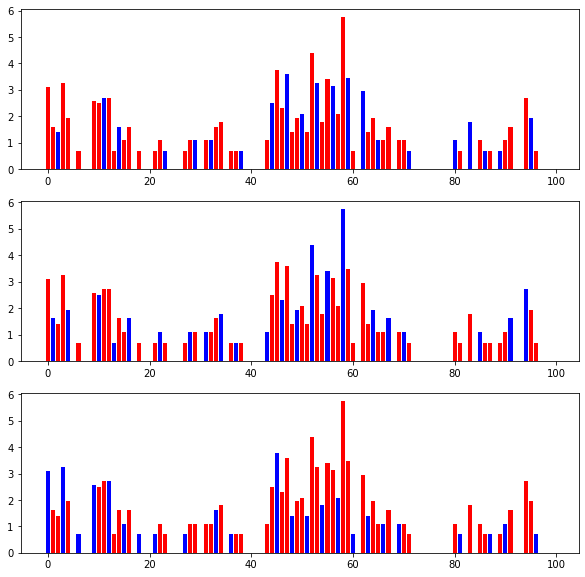

In [7]:
fig,ax = plt.subplots(nrows=3, ncols=1, figsize=(10,10))
x = np.arange(len(pos_counts))

color = ['blue' if pos%3==2 else 'red' for pos in x]
ax[0].bar(x, pos_counts, color=color)

color = ['blue' if pos%3==1 else 'red' for pos in x]
ax[1].bar(x, pos_counts, color=color)

color = ['blue' if pos%3==0 else 'red' for pos in x]
ax[2].bar(x, pos_counts, color=color)

#### Вывод: по одному гену не очень видна периодичность (ВАЖНО: данные прологарифмированы)

#### Для нескольких генов

In [9]:
coverage = 100
pos_counts = np.zeros(coverage)

for feature in features:
    start, end = feature.location.start, feature.location.end
    if (end-start) % 3 != 0:
        continue
    if feature.location.strand == 1:
        pos_counts += forward[start:start+coverage]
    else:
        pos_counts += backward[start:start+coverage]
pos_counts = np.log(pos_counts)

<BarContainer object of 100 artists>

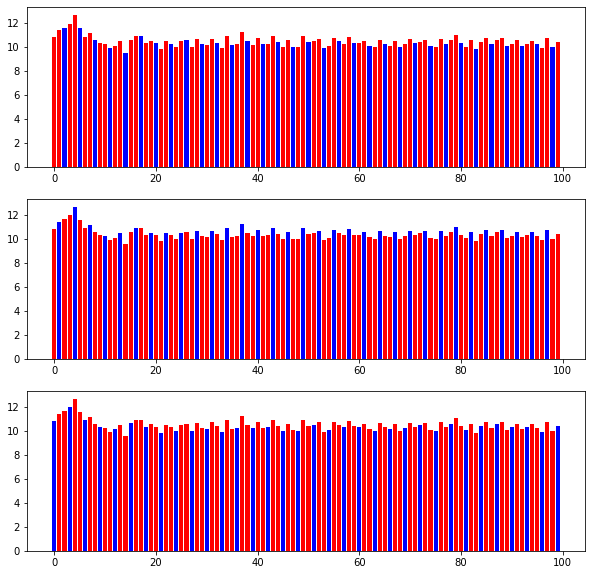

In [10]:
fig,ax = plt.subplots(nrows=3, ncols=1, figsize=(10,10))
x = np.arange(len(pos_counts))

color = ['blue' if pos%3==2 else 'red' for pos in x]
ax[0].bar(x, pos_counts, color=color)

color = ['blue' if pos%3==1 else 'red' for pos in x]
ax[1].bar(x, pos_counts, color=color)

color = ['blue' if pos%3==0 else 'red' for pos in x]
ax[2].bar(x, pos_counts, color=color)

#### ВАЖНО: данные прологарифмированы
#### Вывод: Здесь, на второй картинке видна некоторая периодичность в 3 нуклеотида.

2. Рассчитайте значения RPKM и TPM для каждого гена. В чём разница между RPKM и TPM? Для чего используется каждая метрика?

#### Данные метрики пытаются нормализовать экспрессиипо глубине секвенированя и длине гена

#### Отличие RPKM от TPM в том, что RPKM в начале нормирует на глубину прочтения, а потом на длину. TPM же делает в точности до наоборот. Из-за порядка нормировок TPM позволяет сравнивать различные образцы, так как сумма нормированных TPM в каждом образце одинаковая (из-за того, что последняя нормировка была на глубину прочтения в каждом образце)

In [14]:
gene_counts = {}
for feature in features:
    start, end = feature.location.start, feature.location.end
    if feature.location.strand == 1:
        gene_counts[feature.id] = forward[start:end].sum()
    else:
        gene_counts[feature.id] = backward[start:end].sum()

In [15]:
RPKM = {}
TPM = {}

RPKM_depth = sum(gene_counts.values())/1e6
TPM_depth = 0
for feature in features:
    start, end = feature.location.start, feature.location.end
    length = end - start 
    TPM_depth += gene_counts[feature.id]/length
TPM_depth /= 1e6
    
    
for feature in features:
    RPKM[feature.id] = gene_counts[feature.id] / RPKM_depth / length
    TPM[feature.id] = gene_counts[feature.id] / length / TPM_depth

3. Проанализируйте значения RPKM для генов из оперона ATP. Укажите геномные координаты оперона, а также то, какие гены в него входят. Есть ли разница между RPKM у различных генов, присутствующих в опероне? Как вы можете объяснить эту разницу с биологической точки зрения? Как вы думаете, можно ли оценить эту разницу при помощи классического RNA-Seq?

In [16]:
ATP = []
for feature in features:
    if "ATP synthase" in feature.qualifiers["product"][0] and not " ATP synthase" in feature.qualifiers["product"][0]:
        ATP.append(feature)
        
print('\t\t product \t\t |\t location     | strand  | RPKM')
print('-'*100)
for feature in ATP:
    print(f"{feature.qualifiers['product'][0]:40} | {int(feature.location.start),int(feature.location.end)} |    {feature.location.strand}   | {np.round(RPKM[feature.id],3)}")

		 product 		 |	 location     | strand  | RPKM
----------------------------------------------------------------------------------------------------
ATP synthase F1 complex subunit epsilon  | (3915552, 3915972) |    -1   | 0.698
ATP synthase F1 complex subunit beta     | (3915992, 3917375) |    -1   | 5.087
ATP synthase F1 complex subunit gamma    | (3917401, 3918265) |    -1   | 0.761
ATP synthase F1 complex subunit alpha    | (3918315, 3919857) |    -1   | 4.41
ATP synthase F1 complex subunit delta    | (3919869, 3920403) |    -1   | 0.564
ATP synthase Fo complex subunit b        | (3920417, 3920888) |    -1   | 0.775
ATP synthase Fo complex subunit c        | (3920949, 3921189) |    -1   | 4.313
ATP synthase Fo complex subunit a        | (3921235, 3922051) |    -1   | 1.381
ATP synthase accessory factor AtpI       | (3922059, 3922440) |    -1   | 0.031


#### Исходя из метрики RPKM, различия есть. Скорее всего RNA-seq выдаст одинаковую экспрессию, так как они расположены в одном опероне